In [33]:
import pandas as pd
from os.path import join
mimic_path = "C:\\Users\\fjn197\\PhD\\projects\\PHAIR\\pipelines\\ehr_preprocess\\data\\processed\\mimic-iii-clinical-database-1.4"

## Explore patient information

In [34]:
patients = pd.read_parquet(join(mimic_path,"patients_info.parquet"))
patients.GENDER.value_counts(), patients.INSURANCE.value_counts()

(M    26121
 F    20399
 Name: GENDER, dtype: int64,
 Medicare      20927
 Private       19163
 Medicaid       4369
 Government     1498
 Self Pay        563
 Name: INSURANCE, dtype: int64)

In [35]:
# how many have a death date?
patients.DEATHDATE.notnull().sum()

15759

In [36]:
patients.BIRTHDATE 

0       2075-03-13
1       2164-12-27
2       2090-03-15
3       2078-03-06
4       2089-11-26
           ...    
46515   2026-05-25
46516   2124-07-27
46517   2049-11-26
46518   2076-07-25
46519   2098-07-25
Name: BIRTHDATE, Length: 46520, dtype: datetime64[ns]

<AxesSubplot: >

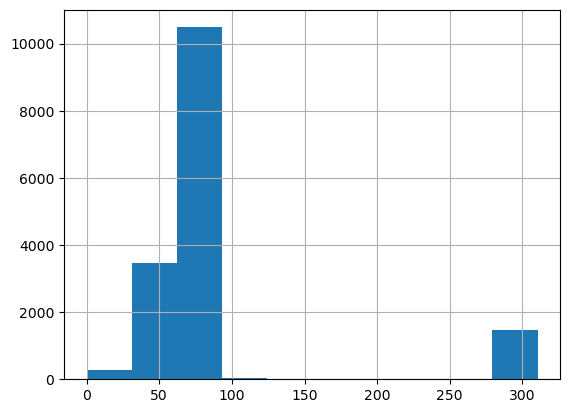

In [41]:
# compute average age of death
patients['death_age'] = patients.DEATHDATE.dt.date - patients.BIRTHDATE.dt.date
death_age = patients[patients.death_age.notnull()]['death_age'].map(lambda x: x.days / 365.25)
death_age.hist()

In [59]:
# there are obviously some errors in either birthdate or deathdate

In [45]:
transfers = pd.read_parquet(join(mimic_path, "concept.transfer.parquet"))
transfers["TIMESTAMP"] = transfers["TIMESTAMP"].dt.date
transfers[transfers.CONCEPT=="THOSPITAL"]

,PID,ADMISSION_ID,TIMESTAMP,TIMESTAMP_END,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,CONCEPT,ICUSTAY_ID
211,2,163353,2138-07-17,2138-07-21 15:48:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,THOSPITAL,<NA>
212,3,145834,2101-10-20,2101-10-31 13:58:00,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,THOSPITAL,<NA>
213,4,185777,2191-03-16,2191-03-23 18:41:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,THOSPITAL,<NA>
214,5,178980,2103-02-02,2103-02-04 12:15:00,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,THOSPITAL,<NA>
215,6,107064,2175-05-30,2175-06-15 16:00:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,THOSPITAL,<NA>
...,...,...,...,...,...,...,...,...,...
56435,99985,176670,2181-01-27,2181-02-12 17:05:00,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,THOSPITAL,<NA>
56436,99991,151118,2184-12-24,2185-01-05 12:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,THOSPITAL,<NA>
56437,99992,197084,2144-07-25,2144-07-28 17:56:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,THOSPITAL,<NA>
56565,99995,137810,2147-02-08,2147-02-11 13:15:00,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,THOSPITAL,<NA>


In [78]:
patients.iloc[46497], transfers[transfers.PID == 44019]
# we see that deathdate corresponds to the vistts

(PID                               44019
 GENDER                                F
 BIRTHDATE                    1901-01-14
 DEATHDATE                    2201-01-14
 INSURANCE                      Medicare
 LANGUAGE                           None
 RELIGION                  NOT SPECIFIED
 MARITAL_STATUS                  MARRIED
 ETHNICITY         UNKNOWN/NOT SPECIFIED
 death_age          109573 days, 0:00:00
 Name: 46497, dtype: object,
           PID  ADMISSION_ID   TIMESTAMP       TIMESTAMP_END ADMISSION_TYPE  \
 103192  44019        125484  2201-01-13 2201-01-14 00:10:00           None   
 103193  44019        125484  2201-01-14 2201-01-14 14:45:00      EMERGENCY   
 103194  44019        125484  2201-01-14 2201-01-14 18:43:55           None   
 
                ADMISSION_LOCATION DISCHARGE_LOCATION     CONCEPT  ICUSTAY_ID  
 103192                       None               None  TEMERGENCY        <NA>  
 103193  CLINIC REFERRAL/PREMATURE       DEAD/EXPIRED   THOSPITAL        <NA>  
 10

### We drop birthdate for patients with age at admission > 100

In [46]:
transfers = pd.merge(transfers, patients[["PID", "BIRTHDATE"]], on="PID", how="left")
transfers["BIRTHDATE"] = transfers["BIRTHDATE"].dt.date
transfers["age"] = (transfers.TIMESTAMP - transfers.BIRTHDATE).map(lambda x: x.days / 365.25)

In [48]:
remove_pids = transfers[transfers.age > 100].PID.unique()

In [49]:
remove_pids

<IntegerArray>
[   19,    30,    34,    56,   112,   149,   151,   166,   175,   213,
 ...
 98932, 99081, 99162, 99186, 99206, 99333, 99441, 99483, 99635, 99936]
Length: 1991, dtype: Int32

<AxesSubplot: >

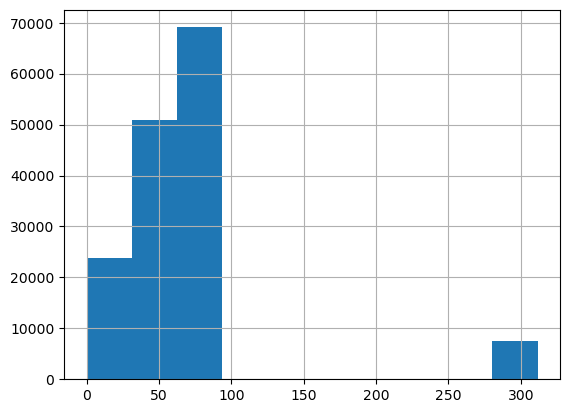

In [47]:
transfers.age.hist()

We should replace values occuring in less than 1% with a RARE token